<a href="https://colab.research.google.com/github/Phatdeluxe/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/module2-sampling-confidence-intervals-and-hypothesis-testing/LS_DS_132_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
import pandas as pd
import numpy as np
import scipy.stats as stats

In [6]:
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'

--2019-09-17 20:02:40--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.06s   

2019-09-17 20:02:40 (286 KB/s) - ‘house-votes-84.data’ saved [18171/18171]



In [7]:
df = pd.read_csv('house-votes-84.data', 
                 header=None,
                 names=['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa'])
print(df.shape)
df.head()

(435, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [12]:
df = df.replace({'?': np.NaN, 'n': 0, 'y': 1})

df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
dem = df[df['party'] == 'democrat']
rep = df[df['party'] == 'republican']

In [42]:
dem.ffill(inplace=True)
dem.bfill(inplace=True)
dem.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
2,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,democrat,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [43]:
rep.ffill(inplace=True)
rep.bfill(inplace=True)
rep.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
7,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
10,republican,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [44]:
dem['el-salvador-aid'].describe()

count    267.000000
mean       0.213483
std        0.410535
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: el-salvador-aid, dtype: float64

In [45]:
np.mean(dem['anti-satellite-ban'])

0.7752808988764045

## Numerically represented confidence interval

In [0]:
def confidence_interval(data, confidence=0.95):
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = np.std(data, ddof=1) / np.sqrt(n)
  margin_of_error = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  # print(margin_of_error)
  return (mean, mean - margin_of_error, mean + margin_of_error)

In [81]:
confidence_interval(dem['anti-satellite-ban'])

(0.7752808988764045, 0.7248917176706723, 0.8256700800821367)

## Graphically represented confidence interval

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

In [144]:
type(dem['south-africa'])

pandas.core.series.Series

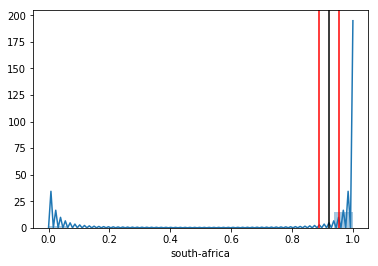

In [140]:
# not sure why most of my graphs look like this

sns.distplot(dem['south-africa'], hist=True)
CI = confidence_interval(dem['south-africa'])
plt.axvline(x=CI[1], color='red')
plt.axvline(x=CI[2], color='red')
plt.axvline(x=CI[0], color='k');


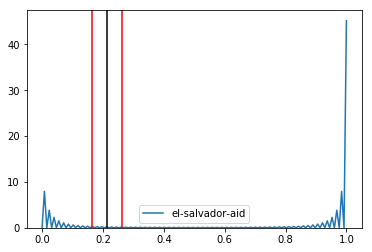

In [150]:
fig, ax= plt.subplots()

sns.kdeplot(dem['el-salvador-aid'])
CI = confidence_interval(dem['el-salvador-aid'])
plt.axvline(x=CI[1], color='red')
plt.axvline(x=CI[2], color='red')
plt.axvline(x=CI[0], color='k');

In [93]:
dem['mx-missile'].describe()

count    267.000000
mean       0.745318
std        0.436500
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: mx-missile, dtype: float64

(0.7453183520599251, 0.6927217730063178, 0.7979149311135325)


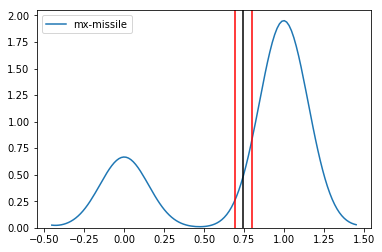

In [88]:
sns.kdeplot(dem['mx-missile'])
CI = confidence_interval(dem['mx-missile'])
print(CI)
plt.axvline(x=CI[1], color='red')
plt.axvline(x=CI[2], color='red')
plt.axvline(x=CI[0], color='k');

## Interpreting the confidence interval

For this data set, the confidence interval is showing what, given a larger population, the voting mean would be. For example, if this sample is truely a reflection of the population, then about 75% of the democratic population will vote yes on the mx-missle issue

## Chi squared tests

In [113]:
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/balloons/adult+stretch.data'
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/balloons/adult-stretch.data'
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/balloons/yellow-small+adult-stretch.data'
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/balloons/yellow-small.data'

--2019-09-17 21:31:19--  https://archive.ics.uci.edu/ml/machine-learning-databases/balloons/adult+stretch.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 547 [application/x-httpd-php]
Saving to: ‘adult+stretch.data.1’

adult+stretch.data. 100%[===================>]     547  --.-KB/s    in 0s      

2019-09-17 21:31:20 (16.5 MB/s) - ‘adult+stretch.data.1’ saved [547/547]

--2019-09-17 21:31:20--  https://archive.ics.uci.edu/ml/machine-learning-databases/balloons/adult-stretch.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 532 [application/x-httpd-php]
Saving to: ‘adult-stretch.data’

adult-stretch.data  100%[===================>]     532  --.-KB/s 

In [114]:
df1 = pd.read_csv('adult+stretch.data', header=None, 
                  names=['Color', 'size', 'act', 'age', 'inflated'])
df1.head()

,Color,size,act,age,inflated
0,YELLOW,SMALL,STRETCH,ADULT,T
1,YELLOW,SMALL,STRETCH,ADULT,T
2,YELLOW,SMALL,STRETCH,CHILD,F
3,YELLOW,SMALL,DIP,ADULT,F
4,YELLOW,SMALL,DIP,CHILD,F


In [115]:
df2 = pd.read_csv('adult-stretch.data', header=None, 
                  names=['Color', 'size', 'act', 'age', 'inflated'])
df2.head()

,Color,size,act,age,inflated
0,YELLOW,SMALL,STRETCH,ADULT,T
1,YELLOW,SMALL,STRETCH,CHILD,T
2,YELLOW,SMALL,DIP,ADULT,T
3,YELLOW,SMALL,DIP,CHILD,F
4,YELLOW,SMALL,DIP,CHILD,F


In [116]:
df3 = pd.read_csv('yellow-small+adult-stretch.data', header=None, 
                  names=['Color', 'size', 'act', 'age', 'inflated'])
df3.head()

,Color,size,act,age,inflated
0,YELLOW,SMALL,STRETCH,ADULT,T
1,YELLOW,SMALL,STRETCH,CHILD,T
2,YELLOW,SMALL,DIP,ADULT,T
3,YELLOW,SMALL,DIP,CHILD,T
4,YELLOW,LARGE,STRETCH,ADULT,T


In [117]:
df4 = pd.read_csv('yellow-small.data', header=None, 
                  names=['Color', 'size', 'act', 'age', 'inflated'])
df4.head()

,Color,size,act,age,inflated
0,YELLOW,SMALL,STRETCH,ADULT,T
1,YELLOW,SMALL,STRETCH,CHILD,T
2,YELLOW,SMALL,DIP,ADULT,T
3,YELLOW,SMALL,DIP,CHILD,T
4,YELLOW,SMALL,STRETCH,ADULT,T


In [120]:
df5 = pd.concat([df1, df2, df3, df4])
df5.head()

,Color,size,act,age,inflated
0,YELLOW,SMALL,STRETCH,ADULT,T
1,YELLOW,SMALL,STRETCH,ADULT,T
2,YELLOW,SMALL,STRETCH,CHILD,F
3,YELLOW,SMALL,DIP,ADULT,F
4,YELLOW,SMALL,DIP,CHILD,F


In [121]:
contingency_table = pd.crosstab(df5['inflated'], df5['size'], margins=True)

contingency_table

size,LARGE,SMALL,All
inflated,,,
F,24,17,41
T,12,23,35
All,36,40,76


## Expected value calculation

In [122]:
row_sums = contingency_table.iloc[0:2, 2].values
col_sums = contingency_table.iloc[2, 0:2].values

print(row_sums)
print(col_sums)

[41 35]
[36 40]


In [123]:
total = contingency_table.loc['All', 'All']
total

76

In [124]:
expected = []
for i in range(len(row_sums)):
  expected_row = []
  for column in col_sums:
    expected_val = column*row_sums[i]/total
    expected_row.append(expected_val)
  expected.append(expected_row)

expected = np.array(expected)
print(expected.shape)
print(expected)

(2, 2)
[[19.42105263 21.57894737]
 [16.57894737 18.42105263]]


In [131]:
observed = pd.crosstab(df5['inflated'], df5['size']).values
print(observed.shape)
observed

(2, 2)


array([[24, 17],
       [12, 23]])

## Chi squared with numpy

In [133]:
chi_squared = ((observed - expected)**2 / (expected)).sum()
print(f'Chi-Squared: {chi_squared}')

Chi-Squared: 4.454076655052262


In [127]:
dof = (len(row_sums) - 1) * (len(col_sums) - 1)
print(f'Degrees of Freedom: {dof}')

Degrees of Freedom: 1


## Chi-Squared with Scipy

In [145]:
# Yates' correction changed my Chi-Squared value from 4.45407 to 3.53446. I do
# not know why you would want or need something like this.

chi_squared, p_value, dof, expected = stats.chi2_contingency(observed, correction=False)

print(f'Chi-Squared: {chi_squared}')
print(f'P-value: {p_value}')
print(f'Degrees of Freedom: {dof}')
print('Expected: \n', np.array(expected))

Chi-Squared: 4.454076655052262
P-value: 0.03481803457936288
Degrees of Freedom: 1
Expected: 
 [[19.42105263 21.57894737]
 [16.57894737 18.42105263]]


## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)